## Estimating the Importance of Missing Articles

Our goal is estimate the importance of the set of articles that exist in English but not in Spanish Wikipedia. As a measure of importance, I use the percentile of the 

#### Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from ConfigParser import SafeConfigParser
from operator import add
from pyspark.mllib.recommendation import ALS, Rating
import random 
from random import randint
import itertools
from math import sqrt
import numpy as np
from pprint import pprint
import math
from ConfigParser import SafeConfigParser
import pandas as pd
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from eval_util import *

from sklearn import cross_validation, grid_search
from sklearn.cross_validation import StratifiedKFold
import multiprocessing
from sklearn.linear_model import LinearRegression
from scipy.sparse import coo_matrix, hstack
import sklearn
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression


def get_parser(names):
    def loadRecord(line):
        cells = line.strip().split('\t')
        return dict(zip(names, cells))
    return loadRecord


def get_X(M, df, index_col, feature_cols):
    if M is None:
        l = []
    else:
        l = [M[df[index_col]], ]
    for col in feature_cols:
         l.append(coo_matrix(df[col].astype('float')).T)
    return hstack(l).toarray()


def spearman(x, y):
    sr = spearmanr(x, y)[0]
    print 'Spearman: %2.5f \n' % sr
    return sr

def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print 'MSE: %2.5f' % mse
    return mse

def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print 'R2: %2.5f' % r2
     return r2

def multi_score(y_true,y_pred):    
    MSE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    R2(y_true,y_pred)
    score = spearman(y_true,y_pred)
    return score

def multi_scorer():
    return make_scorer(multi_score, greater_is_better=True) # change for false if using MSE



def cv (X, y, folds, alg, param_grid, scoring  = multi_scorer()):
    """
    Determine the best model via cross validation. This should be run on training data.
    """

    print "\n\n\nDoing Gridsearch\n"

    kfold_cv = cross_validation.KFold(X.shape[0], n_folds=folds, shuffle=True)
    model = grid_search.GridSearchCV(cv  = kfold_cv, estimator = alg, param_grid = param_grid, scoring = scoring) #n_jobs=multiprocessing.cpu_count()
    model = model.fit(X,y)
    # model trained on all data
    y_pred = model.predict(X)
    print "Best Model Train MSE: %f" % sklearn.metrics.mean_squared_error(y, y_pred)
    print "Best Model Train Spearman %f" % spearman(y, y_pred)


    print("\nBest parameters set found:")
    best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
    print(best_parameters, score)
    print "\n"
    print("Grid scores:")
    for params, mean_score, scores in model.grid_scores_:
        print("%0.5f (+/-%0.05f) for %r"
              % (mean_score, scores.std() / 2, params))

    return model

config = '/home/ellery/wikimedia/missing_articles/missing_articles.ini'
cp = SafeConfigParser()
cp.read(config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['/home/ellery/wikimedia/missing_articles/missing_articles.ini']

In [3]:
s = 'en'
t = 'es'
exp_dir = '%s-%s' % (s, t)

#### Load pagview data

In [4]:
def get_ranking_score(t):
    lang_id, items = t
    items = list(items)
    item_ranks = np.argsort(np.array([x['pageview_count'] for x in items]))
    n = float(len(items))
    for r, i in enumerate(item_ranks):
        items[i]['rank'] = r/n
    return items

def make_counts_float(x):
    x['pageview_count']  = float(x['pageview_count'])  
    return x                                 
                                      
names = [ 'id', 'lang', 'title', 'pageview_count']

pageviews = sc.textFile(cp.get('general', 'pageviews'))\
.map(get_parser(names))\
.filter(lambda x: len(x) == 4)\
.filter(lambda x: ':' not in x['title'])\
.filter(lambda x: x['lang'] == s or x['lang'] == t)\
.map(make_counts_float)\
.map(lambda x: (x['lang'], x))\
.groupByKey()\
.flatMap(get_ranking_score)\
.collect()

s_or_t_views = pd.DataFrame(pageviews, columns = [ 'id', 'lang', 'title', 'pageview_count', 'rank'])
s_or_t_views.index = s_or_t_views.id
del s_or_t_views['id']


#### Load Document Vectors

In [5]:
# Load doc vectors
lda_dir = 'en_lda'
base_dir = os.path.join(cp.get('general', 'local_data_dir'), lda_dir)
dict_file = os.path.join(base_dir, cp.get('LDA', 'article2index'))
id2index, _ , _ = get_universal_maps(dict_file)
mm_file = os.path.join(base_dir, cp.get('LDA', 'doc2topic'))
f = open(mm_file)
M = mmread(f).tocsr()

#### Merge Pageviews and Document Vectors

In [6]:
# Merge 
print 'pre merge', s_or_t_views.shape
id2index_df = pd.DataFrame(id2index.items(), columns = ['id', 'indx'])
id2index_df.index = id2index_df['id']
del id2index_df['id']
s_or_t_views = s_or_t_views.merge(id2index_df, left_index=True, right_index=True)
s_or_t_views['log_pageview_count'] = np.log(s_or_t_views['pageview_count'])
print 'post merge', s_or_t_views.shape

pre merge (5910788, 4)
post merge (5398917, 6)


#### Get Training Data
Training examples come from items that exist in en and es wiki. 

Training features include
- the LDA vector for the english article
- the percentile of the english article
- the log of the pageviews of the english article

The response is the percentile of the article in spanish

In [7]:
# Get Training Data
t_views = s_or_t_views[s_or_t_views['lang'] == t]
del t_views['lang']
del t_views['indx']
t_views.columns = ['title_t', 'pageview_count_t', 'rank_t', 'log_pageview_count_t']
s_views = s_or_t_views[s_or_t_views['lang'] == s]
del s_views['lang']
s_views.columns = ['title_s', 'pageview_count_s', 'rank_s', 'indx', 'log_pageview_count_s']
s_and_t_views = t_views.merge(s_views, left_index=True, right_index=True, copy=True)
s_and_t_views['id'] = s_and_t_views.index

### Getting Dump Features

In [8]:
feature_file = "/home/ellery/en-en/dump_features.tsv"
dump_df = pd.read_csv(feature_file, encoding = 'utf8', sep = '\t')
del dump_df['Unnamed: 0']
dump_df['title'] = dump_df['title'].apply(lambda x: unicode(x).replace(u' ', u'_'))
dump_df['log_length'] = dump_df['length'].apply(np.log)
s_and_t_views = s_and_t_views.merge(dump_df, how = 'inner', left_on = 'title_s', right_on = 'title' )
del s_and_t_views['title']

## Subsample Data for Model Building

In [9]:
# code for sub-sampling training data
fraction = 0.5
rows = random.sample(s_and_t_views.index, int(fraction*s_and_t_views.shape[0]))
s_and_t_views_sample = s_and_t_views.ix[rows]

#### Baselines
What if we simply use the percentile of the article in english as our prediction?

In [10]:
print "Baseline MSE", sklearn.metrics.mean_squared_error(s_and_t_views_sample['rank_s'], s_and_t_views_sample['rank_t'])
print "Baseline Spearman", spearmanr(s_and_t_views_sample['rank_s'], s_and_t_views_sample['rank_t'])


Baseline MSE 0.0764082201391
Baseline Spearman (0.69196575248345271, 0.0)


What if we just use the LDA vectors?

In [48]:
X = get_X(M, s_and_t_views_sample, 'indx', [])
y = s_and_t_views_sample['rank_t'].astype('float').values
model = cv (X, y, 5, LinearRegression(), {})




Doing Gridsearch

MSE: 0.04652
R2: 0.42702
Spearman: 0.65090 

MSE: 0.04663
R2: 0.42589
Spearman: 0.65003 

MSE: 0.04655
R2: 0.42739
Spearman: 0.65144 

MSE: 0.04700
R2: 0.42317
Spearman: 0.64736 

MSE: 0.04659
R2: 0.42694
Spearman: 0.65116 

Best Model Train MSE: 0.046614
Spearman: 0.65061 

Best Model Train Spearman 0.650612

Best parameters set found:
({}, 0.65017874695980782)


Grid scores:
0.65018 (+/-0.00074) for {}


#### Fitting the Model - Predicting Ranks
I experimented with more sophisticated methods (Random Forest Regression, Lasso), but it looks like linear regression can't be beat. The model gets an cv'ed MSE of 0.021, which means that on average, it is 2 percentile points off. This is an improvment of 5.5 percentile points over the baseline. The cv'ed spearman correlation is also drastically higher at 0.86.

In [11]:
full_feature_set = ['rank_s', 'log_pageview_count_s', 'pageview_count_s', 'length', 'log_length', 'is_stub']

In [12]:
X = get_X(M, s_and_t_views_sample, 'indx', full_feature_set)
y = s_and_t_views_sample['rank_t'].astype('float').values

alg = LinearRegression()
param_grid = {}
model = cv (X, y, 5, alg, param_grid)




Doing Gridsearch

MSE: 0.02233
R2: 0.72042
Spearman: 0.85434 

MSE: 0.02231
R2: 0.71858
Spearman: 0.85315 

MSE: 0.02237
R2: 0.71824
Spearman: 0.85350 

MSE: 0.02234
R2: 0.71762
Spearman: 0.85333 

MSE: 0.02235
R2: 0.71889
Spearman: 0.85335 

Best Model Train MSE: 0.022260
Spearman: 0.85398 

Best Model Train Spearman 0.853981

Best parameters set found:
({}, 0.85353358658251277)


Grid scores:
0.85353 (+/-0.00021) for {}


####Fitting Log Views

In [44]:
X = get_X(M, s_and_t_views_sample, 'indx', full_feature_set)
y = s_and_t_views_sample['log_pageview_count_t'].astype('float').values
model = cv (X, y, 5, LinearRegression(), {})




Doing Gridsearch

MSE: 0.64126
R2: 0.70089
Spearman: 0.82664 

MSE: 0.62583
R2: 0.70416
Spearman: 0.82858 

MSE: 0.68395
R2: 0.68627
Spearman: 0.83474 

MSE: 0.63626
R2: 0.70868
Spearman: 0.83122 

MSE: 0.63283
R2: 0.70446
Spearman: 0.82971 

Best Model Train MSE: 0.626099
Spearman: 0.83190 

Best Model Train Spearman 0.831902

Best parameters set found:
({}, 0.83017880492896978)


Grid scores:
0.83018 (+/-0.00136) for {}


#### Fitting Views

In [15]:
X = get_X(M, s_and_t_views_sample, 'indx', full_feature_set)
y = s_and_t_views_sample['pageview_count_t'].astype('float').values
model = cv (X, y, 5, LinearRegression(), {})




Doing Gridsearch

MSE: 3379262746.43368
R2: -3.29225
Spearman: 0.64103 

MSE: 567874405.07260
R2: 0.25481
Spearman: 0.56079 

MSE: 798202738.05062
R2: 0.25721
Spearman: 0.57377 

MSE: 620646704.47069
R2: 0.28687
Spearman: 0.56645 

MSE: 447444857.33070
R2: 0.29517
Spearman: 0.55834 

Best Model Train MSE: 607848716.542980
Spearman: 0.56986 

Best Model Train Spearman 0.569860

Best parameters set found:
({}, 0.58007614646770533)


Grid scores:
0.58008 (+/-0.01547) for {}


#### Loading the missing articles

In [13]:
missing_articles_file = os.path.join(cp.get('general', 'local_data_dir'), exp_dir, cp.get('missing', 'missing_items'))
d_missing = pd.read_csv(missing_articles_file, sep='\t', names = ['id', 'title_s', 'pageview_count_s'], encoding = 'utf8')
d_missing.index = d_missing['id']
d_missing['log_pageview_count_s'] = np.log(d_missing['pageview_count_s'])
d_missing = d_missing.merge(s_views[['indx', 'rank_s']],left_index=True, right_index=True)

In [14]:
d_missing['title_s'] = d_missing['title_s'].apply(lambda x: unicode(x).replace(u' ', u'_'))
d_missing.shape

(3868755, 6)

In [15]:
d_missing = d_missing.merge(dump_df, how= 'inner', left_on = 'title_s', right_on = 'title')
del d_missing['title']
d_missing.index = d_missing['id']

In [16]:
d_missing.shape

(3868598, 10)

In [17]:
d_missing.head()

,id,title_s,pageview_count_s,log_pageview_count_s,indx,rank_s,length,is_dis,is_stub,log_length
id,,,,,,,,,,
Q100000,Q100000,Cadier_en_Keer,699,6.549651,3703458,0.340215,2327,False,True,7.752335
Q1000000,Q1000000,Water_crisis_in_Iran,1584,7.367709,612799,0.692669,9439,False,False,9.152605
Q1000004,Q1000004,New_Hampshire_Route_16,5379,8.590258,263308,0.855872,22777,False,False,10.033507
Q1000005,Q1000005,Karel_Matěj_Čapek-Chod,1273,7.149132,2211181,0.588291,2291,False,True,7.736744
Q1000013,Q1000013,Jaguar_XK140,16222,9.694124,4401886,0.942489,7607,False,False,8.936824


In [18]:
(d_missing['pageview_count_s'] > 1000).sum()


1723985

In [19]:
# Sanity Check Did not train in missing articles
d_missing.merge(s_and_t_views_sample,left_index=True, right_on='id').shape

(5486, 25)

#### Apply our model to the mssing articles

In [20]:
X_missing = get_X(M, d_missing, 'indx', full_feature_set)
rank_t = model.predict(X_missing)
d_missing['rank_t'] = rank_t

In [21]:
d_missing = d_missing.sort('rank_t', ascending = False)
d_missing.head(10)

,id,title_s,pageview_count_s,log_pageview_count_s,indx,rank_s,length,is_dis,is_stub,log_length,rank_t
id,,,,,,,,,,,
Q3490506,Q3490506,Former_FBI_Ten_Most_Wanted_Fugitives,23295,10.055994,4371574,0.957612,1580,False,False,7.365180,1.468341
Q18702116,Q18702116,La_esquina_del_diablo,14120,9.555348,4062932,0.931640,4036,False,True,8.303009,1.392375
Q4788652,Q4788652,Area_codes_in_Mexico_by_code_(400-499),7304,8.896177,2869722,0.883391,59386,False,False,10.991814,1.359949
Q17004397,Q17004397,Area_codes_in_Mexico_by_code_(700-799),5416,8.597113,1279379,0.863004,35496,False,False,10.477175,1.348232
Q16959919,Q16959919,Odd_Thomas_(novel),84721,11.347119,1321282,0.987730,20189,False,False,9.912893,1.342388
Q3257188,Q3257188,Livraria_Cultura,8650,9.065315,333388,0.905505,646,False,True,6.470800,1.324503
Q18230618,Q18230618,Señora,10845,9.291459,4703986,0.911737,296,False,False,5.690359,1.319826
Q7573371,Q7573371,Spanish_football_top_scorers,180735,12.104787,4510107,0.994796,21834,False,False,9.991224,1.319226
Q3840416,Q3840416,Luis_Segura,3472,8.152486,2009198,0.800496,5762,False,False,8.659040,1.307874


In [22]:
del d_missing['id']

In [23]:
ranked_missing_articles_file = os.path.join(cp.get('general', 'local_data_dir'), exp_dir, cp.get('missing', 'ranked_missing_items'))
d_missing.to_csv(ranked_missing_articles_file, sep='\t', encoding='utf-8')

#Scratch

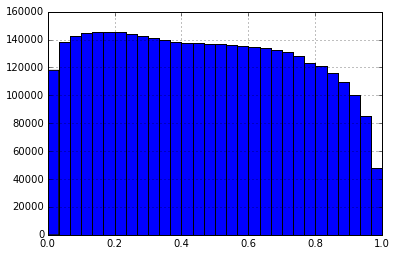

In [24]:
d_missing['rank_s'].hist(bins=30)

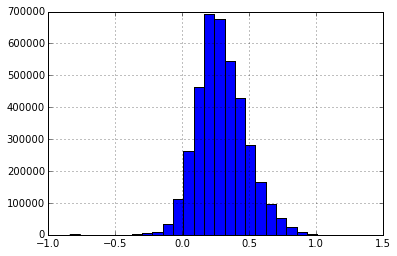

In [25]:
d_missing['rank_t'].hist(bins=30)

In [125]:

# compute spearman correlation between en as es ranks on missing articles
print "Baseline Spearman", spearmanr(d_missing_k['rank_en'], d_missing_k['rank_es'])

Baseline Spearman (0.76148637933899221, 0.0)


In [126]:
from sklearn.linear_model import Lasso
alg = Lasso()
param_grid = {'alpha': [0.000001, 0.0001, 0.001, 1]}
model = cv (X, y, 2, alg, param_grid)




Doing Gridsearch

MSE: 0.02139
R2: 0.73260
Spearman: 0.86140 

MSE: 0.02148
R2: 0.73211
Spearman: 0.86140 

MSE: 0.02309
R2: 0.71128
Spearman: 0.84927 

MSE: 0.02319
R2: 0.71080
Spearman: 0.84913 

MSE: 0.02639
R2: 0.66998
Spearman: 0.82518 

MSE: 0.02649
R2: 0.66964
Spearman: 0.82518 

MSE: 0.07998
R2: -0.00001
Spearman: nan 

MSE: 0.08019
R2: -0.00001
Spearman: nan 

Best Model Train MSE: 0.021394
Spearman: 0.86169 

Best Model Train Spearman 0.861693

Best parameters set found:
({'alpha': 1e-06}, 0.86140266086482908)


Grid scores:
0.86140 (+/-0.00000) for {'alpha': 1e-06}
0.84920 (+/-0.00003) for {'alpha': 0.0001}
0.82518 (+/-0.00000) for {'alpha': 0.001}
nan (+/-nan) for {'alpha': 1}


In [62]:
model.best_estimator_

Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute='auto', tol=0.0001,
   warm_start=False)

In [54]:
from sklearn.ensemble import RandomForestRegressor
alg = RandomForestRegressor()
param_grid = {'n_jobs' : [8], 'n_estimators' : [50, 500 ], 'max_depth' : [2, 3, 4 ] }
cv (X, y, 2, alg, param_grid)




Doing Gridsearch

Best Model Train MSE: 0.024215

Best parameters set found:
({'n_estimators': 50, 'n_jobs': 8, 'max_depth': 4}, -0.024152132858999739)


Grid scores:
-0.03364 (+/-0.00021) for {'n_estimators': 50, 'n_jobs': 8, 'max_depth': 2}
-0.03378 (+/-0.00018) for {'n_estimators': 500, 'n_jobs': 8, 'max_depth': 2}
-0.02695 (+/-0.00007) for {'n_estimators': 50, 'n_jobs': 8, 'max_depth': 3}
-0.02700 (+/-0.00005) for {'n_estimators': 500, 'n_jobs': 8, 'max_depth': 3}
-0.02415 (+/-0.00003) for {'n_estimators': 50, 'n_jobs': 8, 'max_depth': 4}
-0.02424 (+/-0.00008) for {'n_estimators': 500, 'n_jobs': 8, 'max_depth': 4}


GridSearchCV(cv=sklearn.cross_validation.KFold(n=70617, n_folds=2, shuffle=True, random_state=None),
       estimator=RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=10, n_jobs=1, oob_score=False,
           random_state=None, verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [50, 500], 'n_jobs': [8], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_squared_error', verbose=0)

In [57]:
from sklearn.linear_model import LinearRegression
alg = Lasso()
param_grid = {}
model = cv (rank_en.toarray(), y, 2, alg, param_grid)





Doing Gridsearch

Best Model Train MSE: 0.080153

Best parameters set found:
({}, -0.080153485281797415)


Grid scores:
-0.08015 (+/-0.00002) for {}


In [59]:
from sklearn.linear_model import LinearRegression
alg = Lasso()
param_grid = {}
model = cv (M_r.toarray(), y, 2, alg, param_grid)





Doing Gridsearch

Best Model Train MSE: 0.080153

Best parameters set found:
({}, -0.080153429784761906)


Grid scores:
-0.08015 (+/-0.00011) for {}
